<a href="https://colab.research.google.com/github/lucianozablocki/tiny_md/blob/main/cp_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
path="/content/20250325T182411.csv"

In [2]:
# df = pd.read_csv("https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/20250322T164930.csv")
df = pd.read_csv(path)

In [3]:
df

,particulas/s,N,opt,compiler,runs
0,171.061,4,-O0,gcc,20
1,191.373,4,-O0,gcc,20
2,196.257,4,-O0,gcc,20
3,199.468,4,-O0,gcc,20
4,201.115,4,-O0,gcc,20
...,...,...,...,...,...
515,34.987,256,-Ofast,clang,5
516,35.363,256,-Ofast,clang,5
517,35.130,256,-Ofast,clang,5
518,21.440,500,-Ofast,clang,2


In [4]:
print(f"Length of original df: {len(df)}")
print("\nUnique values in each column:")
print(f"N values: {df['N'].unique()}")
print(f"opt flags: {df['opt'].unique()}")
print(f"compilers: {df['compiler'].unique()}")

Length of original df: 520

Unique values in each column:
N values: [  4  32 108 256 500]
opt flags: ['-O0' '-O1' '-O2' '-O3' '-Ofast']
compilers: ['gcc' 'clang']


In [6]:
print(20*(5*2)+15*(5*2)+10*(5*2)+5*(5*2)+2*(5*2))

520


In [9]:
# Create a cross product of all possible combinations
compilers = ['gcc', 'clang']
opt_flags = ['-O0', '-O1', '-O2', '-O3', '-Ofast']
Ns = [4*m**3 for m in range(1,5+1)]  # [4, 32, 108, 256, 500]

# Create all possible combinations
all_combinations = pd.MultiIndex.from_product(
    [Ns, opt_flags, compilers],
    names=['N', 'opt', 'compiler']
).to_frame(index=False)

# Count measurements for each combination
counts = df.groupby(['N', 'opt', 'compiler']).size().reset_index(name='count')

# Merge to see which combinations have fewer than 5 measurements
analysis = all_combinations.merge(counts, how='left', on=['N', 'opt', 'compiler'])

# Print summary statistics
print("\nSummary:")
print(f"Total rows in df: {len(df)}")
print("\nMeasurement counts:")
print(analysis['count'].value_counts())


Summary:
Total rows in df: 520

Measurement counts:
count
20    10
15    10
10    10
5     10
2     10
Name: count, dtype: int64


In [21]:
df_max = df.groupby(['N', 'opt', 'compiler'])['particulas/s'].max().reset_index()

In [22]:
df_max

,N,opt,compiler,particulas/s
0,4,-O0,clang,172.684
1,4,-O0,gcc,211.368
2,4,-O1,clang,448.648
3,4,-O1,gcc,374.810
4,4,-O2,clang,562.937
5,4,-O2,gcc,542.001
6,4,-O3,clang,419.775
7,4,-O3,gcc,527.602
8,4,-Ofast,clang,578.933
9,4,-Ofast,gcc,572.200


In [23]:
df=df_max

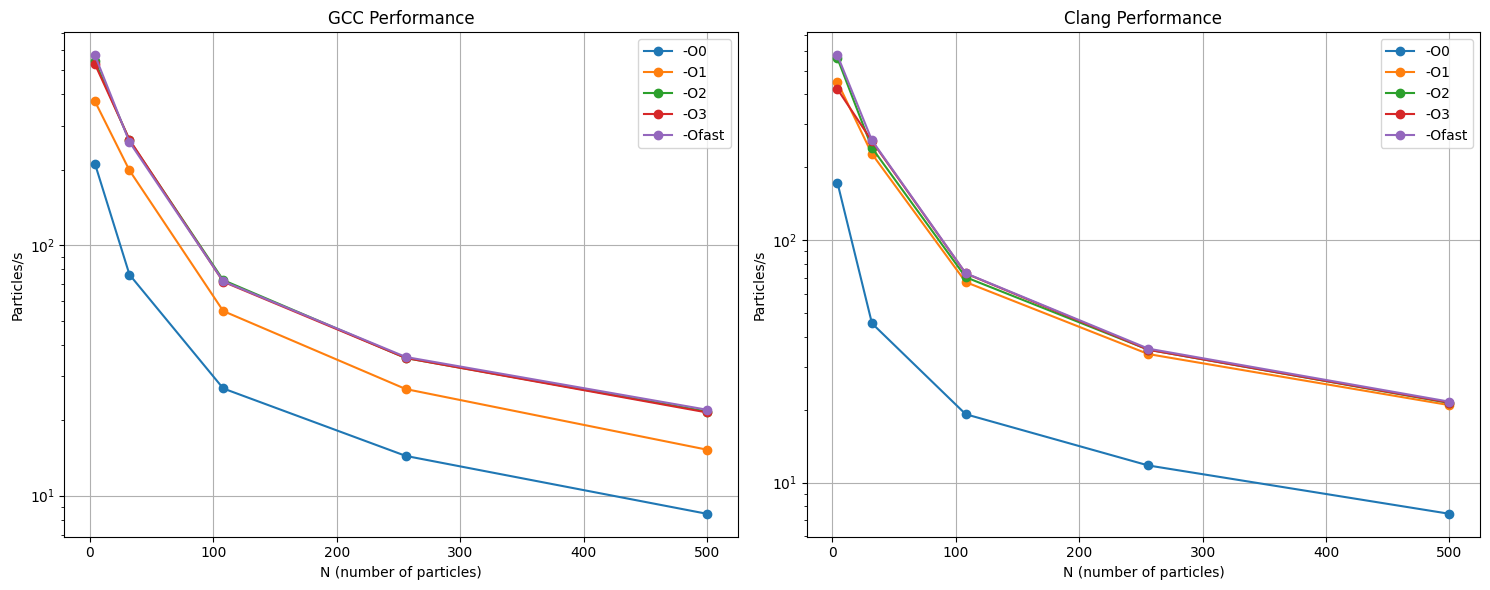

In [25]:
plt.figure(figsize=(15, 6))

# Plot for GCC
plt.subplot(1, 2, 1)
for opt in df['opt'].unique():
    data = df[(df['compiler'] == 'gcc') & (df['opt'] == opt)]
    plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

plt.title('GCC Performance')
plt.xlabel('N (number of particles)')
plt.ylabel('Particles/s')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Plot for Clang
plt.subplot(1, 2, 2)
for opt in df['opt'].unique():
    data = df[(df['compiler'] == 'clang') & (df['opt'] == opt)]
    plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

plt.title('Clang Performance')
plt.xlabel('N (number of particles)')
plt.ylabel('Particles/s')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()